# Global inducing points for BNNs

In [99]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from check_shape import check_shape

tfk = tf.keras
tfd = tfp.distributions



## Prior


## Approximate posterior

The neural network takes the form

$$\begin{align}
\mathbf{F}_1 &= \mathbf{X} \mathbf{W}_1, \\
\mathbf{F}_l &= \phi(\mathbf{F}_{l - 1}) \mathbf{W}_l.
\end{align}$$

The approximate posterior takes the form

$$\begin{align}
q\left(\mathbf{W}_l | \{\mathbf{W}_{l'}\}_{l' = 1}^{l-1}\right) &\propto \prod_{d = 1}^{D_l} \mathcal{N}\left(\mathbf{v}^l_d; \phi(\mathbf{F}_{l-1}) \mathbf{w}^l_d, \boldsymbol{\Lambda}^{-1}_l\right) p(\mathbf{w}^l_d),
\end{align}$$



which, if we rearrange to explicitly be in the form of a distrubution over the $\mathbf{w}_d^l$ weights, becomes

$$\begin{align}
q\left(\mathbf{W}_l | \{\mathbf{W}_{l'}\}_{l' = 1}^{l-1}\right) &= \prod_{d = 1}^{D_l} \mathcal{N}\left(\mathbf{w}^l_d; \boldsymbol{\mu}_l^w, \boldsymbol{\Sigma}_l^w\right), \\
                                          \boldsymbol{\mu}_l^w  &= \boldsymbol{\Sigma}_l^w \phi\left(\mathbf{F}_{l-1}\right)^\top \boldsymbol{\Lambda}_l \mathbf{v}_d^l, \\
                                       \boldsymbol{\Sigma}_l^w  &= \left( D_l \mathbf{I} + \phi\left(\mathbf{F}_{l-1}\right)^\top \boldsymbol{\Lambda}_l \phi\left(\mathbf{F}_{l-1}\right) \right)^{-1}.
\end{align}$$

In [240]:
class GlobalInducingDenseLayer(tfk.layers.Layer):
    
    def __init__(self,
                 num_input,
                 num_output,
                 num_inducing,
                 nonlinearity,
                 dtype,
                 name="global_inducing_fully_connected_layer",
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        self.num_input = num_input
        self.num_output = num_output
        self.num_inducing = num_inducing
        
        # Set nonlinearity for the layer
        self.nonlinearity = (lambda x: x) if nonlinearity is None else \
                            getattr(tf.nn, nonlinearity)
    
    def build(self, input_shape):
        
        # Set up prior mean, scale and distribution
        self.prior_mean = tf.zeros(
            shape=(self.num_output, self.num_input),
            dtype=self.dtype
        )
        
        self.prior_scale = tf.ones(
            shape=(self.num_output, self.num_input),
            dtype=self.dtype
        )
        self.prior_scale = self.prior_scale / self.num_input**0.5
        
        self.prior = tfd.MultivariateNormalDiag(
            loc=self.prior_mean,
            scale_diag=self.prior_scale
        )
        
        # Set up pseudo observation means and variances
        self.pseudo_means = tf.zeros(
            shape=(self.num_inducing, self.num_output),
            dtype=self.dtype
        )
        self.pseudo_mean = tf.Variable(self.pseudo_means)
        
        self.pseudo_log_prec = 5. * tf.ones(
            shape=(self.num_inducing,),
            dtype=self.dtype
        )
        self.pseudo_log_prec = tf.Variable(self.pseudo_log_prec, trainable=False)
        
        
    @property
    def pseudo_precision(self):
        return tf.math.exp(self.pseudo_log_precision)
    
        
    def q_prec_cov_chols(self, Uin):
        
        phiU = self.nonlinearity(Uin)
        pseudo_prec = tf.math.exp(self.pseudo_log_prec)
        
        # Compute precision matrix of multivariate normal
        phiT_lambda_phi = tf.einsum("mi, m, mj -> ij", phiU, pseudo_prec, phiU)
        
        q_prec = tf.linalg.diag(self.prior_scale[0, :]**-2.) + phiT_lambda_phi
        
        # Compute cholesky of approximate posterior precision
        q_prec_chol = tf.linalg.cholesky(q_prec)
        
        # Compute cholesky of approximate posterior covariance
        iq_prec_chol = tf.linalg.triangular_solve(
            q_prec_chol,
            tf.eye(q_prec_chol.shape[0]),
            lower=True
        )
        
        q_cov = tf.matmul(iq_prec_chol, iq_prec_chol, transpose_a=True)
        q_cov_chol = tf.linalg.cholesky(q_cov)
        
        return q_prec_chol, q_cov_chol
    
    
    def q_mean(self, Uin, prec_chol):
        
        phiU = self.nonlinearity(Uin)
        pseudo_prec = tf.math.exp(self.pseudo_log_prec)
        
        mean = tf.matmul(
            phiU,
            pseudo_prec[:, None] * self.pseudo_mean,
            transpose_a=True
        )
        
        mean = tf.linalg.cholesky_solve(prec_chol, mean)
        mean = tf.transpose(mean, [1, 0])
        
        return mean
        
        
    def call(self, Fin, Uin):
        
        Din = self.num_input
        Dout = self.num_output
        M = self.num_inducing
        
        # Check shape of input features Fin and pseudo-means
        check_shape(
            [Fin, Uin, self.pseudo_means],
            [(-1, Din), (M, Din), (M, Dout)]
        )
        
        # Compute cholesky factors of q precision and covariance.
        # These are common between all weight columns, i.e. the covariance
        # between weights leading to a neuron in the next layer is shared
        # between all next neurons.
        q_prec_chol, q_cov_chol = self.q_prec_cov_chols(Uin)
        
        check_shape(
            [q_prec_chol, q_cov_chol],
            [(Din, Din), (Din, Din)]
        )
        
        # Compute means of q. There is a different mean vector for
        # each column of weights.
        q_mean = self.q_mean(Uin, q_prec_chol)
        
        check_shape(q_mean, (Dout, Din))
        
        # Sample approximate posterior for the weights
        q_cov_chol = tf.stack([q_cov_chol]*Dout, axis=0)
        q = tfd.MultivariateNormalTriL(loc=q_mean, scale_tril=q_cov_chol)
        wT = q.sample()
        w = tf.transpose(wT, [1, 0])
        
        check_shape(w, (Din, Dout))
        
        # Compute contibution to ELBO
        kl_term = q.kl_divergence(self.prior)
        kl_term = tf.reduce_sum(kl_term)
        
        # Compute Fout and Uout and return
        Fout = tf.matmul(self.nonlinearity(Fin), w)
        Uout = tf.matmul(self.nonlinearity(Uin), w)
        
        return Fout, Uout, kl_term

In [244]:
class GlobalInducingFullyConnectedNetwork(tfk.Model):

    def __init__(self,
                 num_input,
                 num_output,
                 inducing_points,
                 nonlinearity,
                 dtype,
                 name="global_inducing_fully_connected",
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        self.num_input = num_input
        self.num_output = num_output
        self.inducing_points = inducing_points
        self.num_inducing = inducing_points.shape[0]
        self.nonlinearity = nonlinearity
        self.num_hidden = [50, 50]
        
        
    def build(self, input_shape):
        
        self.inducing_points = tf.Variable(self.inducing_points, trainable=False)
        
        self.l1 = GlobalInducingDenseLayer(
            num_input=self.num_input,
            num_output=self.num_hidden[0],
            num_inducing=self.num_inducing,
            nonlinearity=None,
            dtype=self.dtype
        )
        
        self.l2 = GlobalInducingDenseLayer(
            num_input=self.num_hidden[0],
            num_output=self.num_hidden[1],
            num_inducing=self.num_inducing,
            nonlinearity=self.nonlinearity,
            dtype=self.dtype
        )
        
        self.l3 = GlobalInducingDenseLayer(
            num_input=self.num_hidden[1],
            num_output=2*self.num_output,
            num_inducing=self.num_inducing,
            nonlinearity=self.nonlinearity,
            dtype=self.dtype
        )
        
        
    def call(self, x):
        
        F1, U1, kl1 = self.l1(x, self.inducing_points)
        F2, U2, kl2 = self.l2(F1, U1)
        F3, _, kl3 = self.l3(F2, U2)
        
        means = F3[:, ::2]
        scales = tf.math.exp(F3[:, 1::2])
        scales = 1e-1 * tf.ones_like(scales)
        
        return means, scales, [kl1, kl2, kl3]
    
    
    def elbo(self, x, y):
        
        means, scales, kls = self(x)
        
        cond_lik = tfd.Normal(loc=means, scale=scales)
        cond_lik = tf.reduce_sum(cond_lik.log_prob(y))
        
        kl = tf.reduce_sum(kls)
        
        elbo = cond_lik # - kl
        
        return elbo, cond_lik, kl

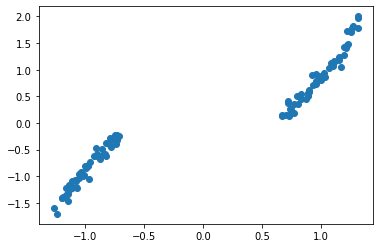

In [245]:
num_data = 100
num_input = 1
std_noise = 3.

x1 = tf.random.uniform(minval=-4., maxval=-2., shape=(num_data // 2, 1))
x2 = tf.random.uniform(minval=2., maxval=4., shape=(num_data // 2, 1))

x = tf.concat([x1, x2], axis=0)
y = tf.concat([x1, x2], axis=0) ** 3. + std_noise * tf.random.normal(shape=(num_data, 1))

x = (x - tf.reduce_mean(x)) / tf.math.reduce_std(x)
y = (y - tf.reduce_mean(y)) / tf.math.reduce_std(y)

plt.scatter(x[:, 0], y[:, 0])
plt.show()

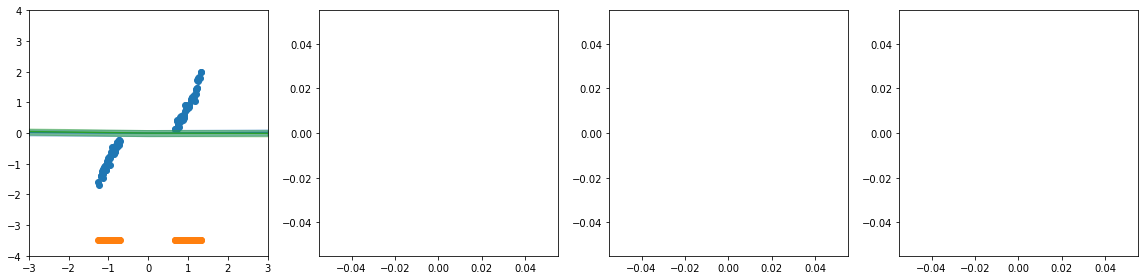

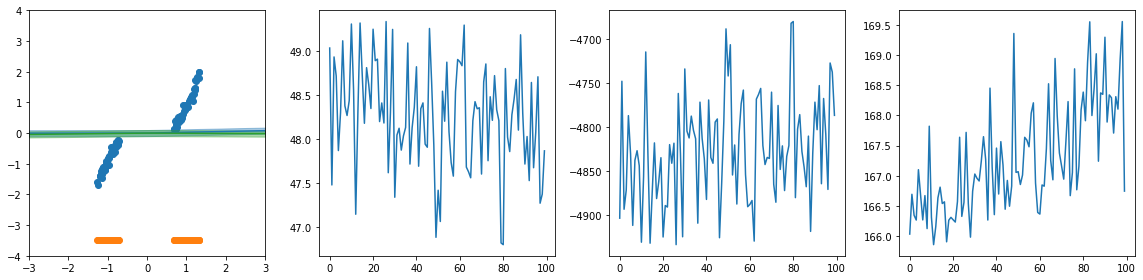

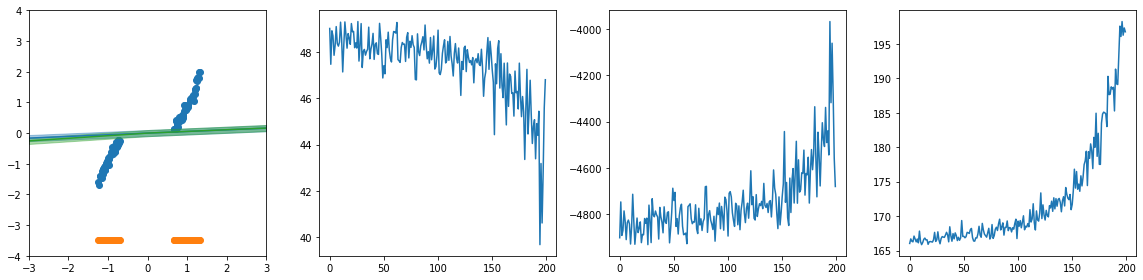

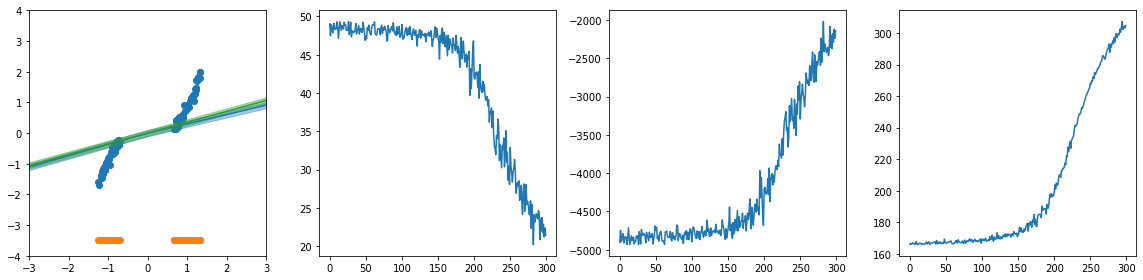

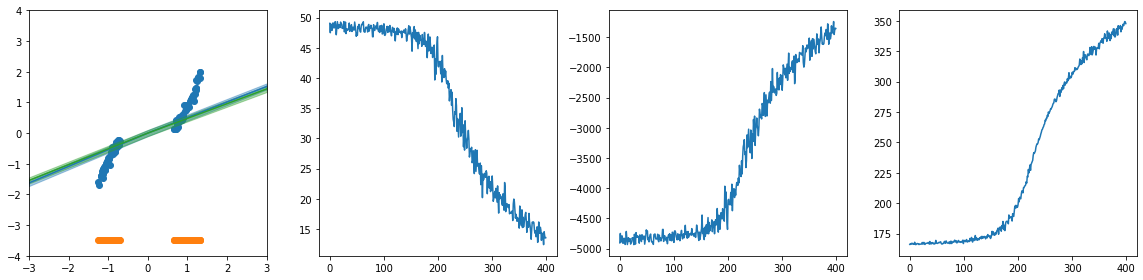

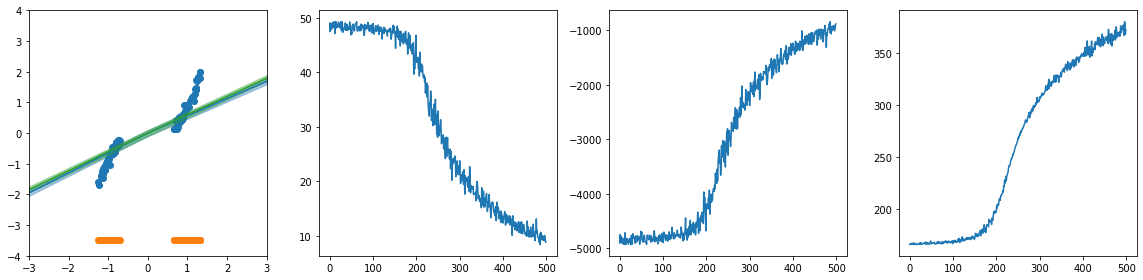

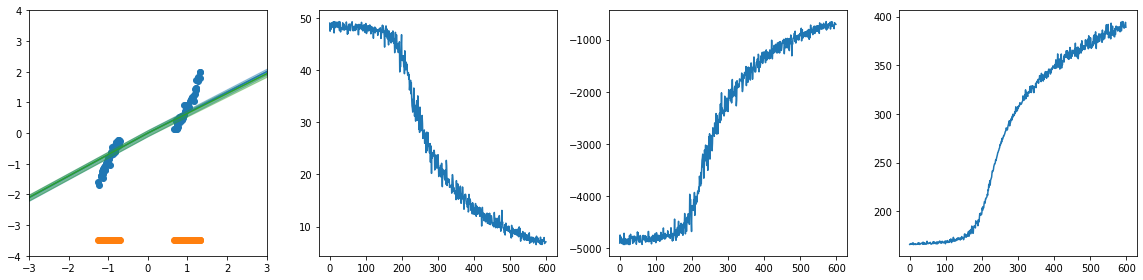

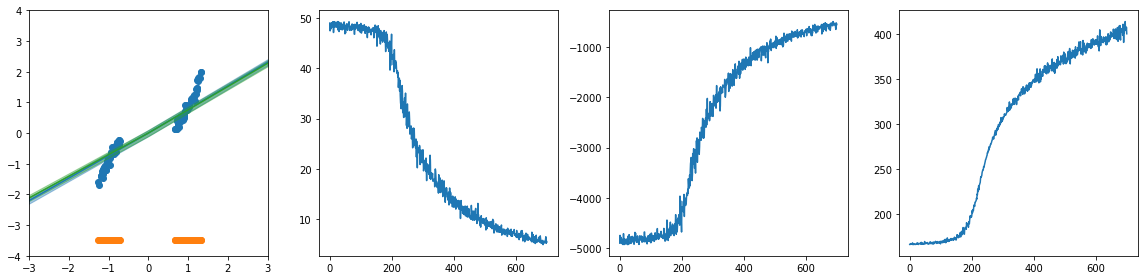

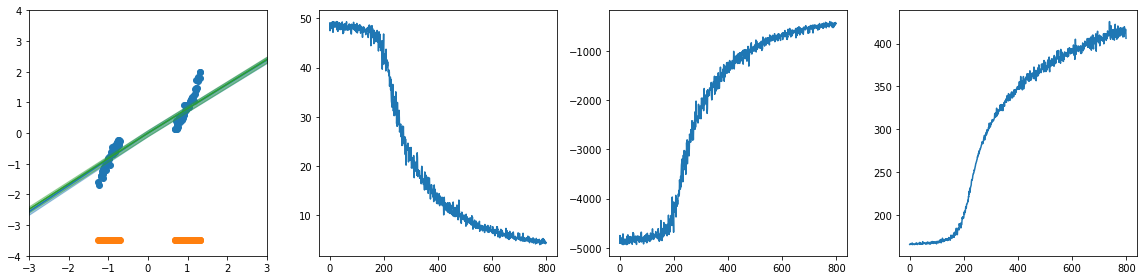

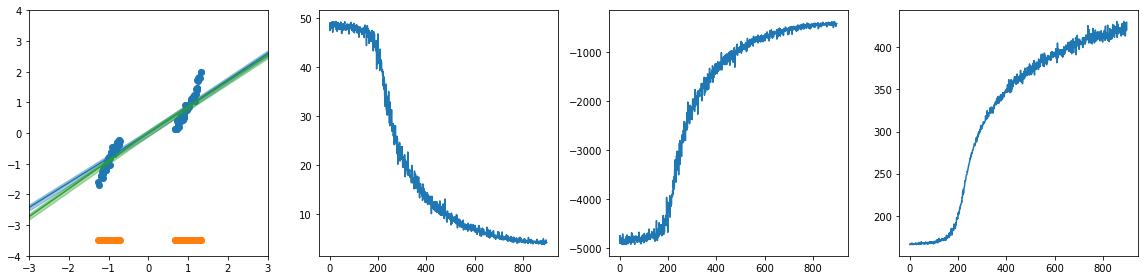

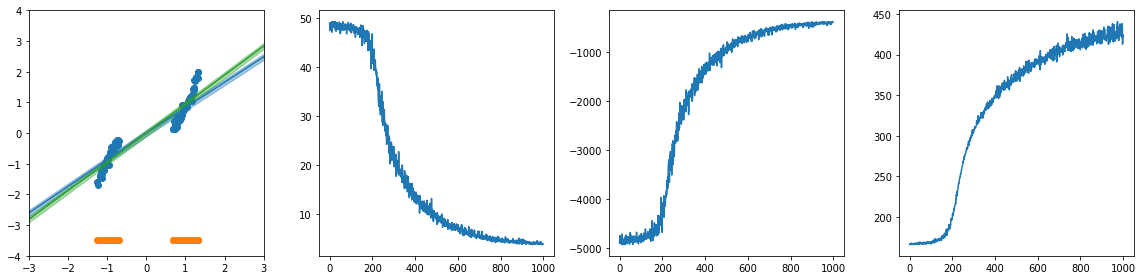

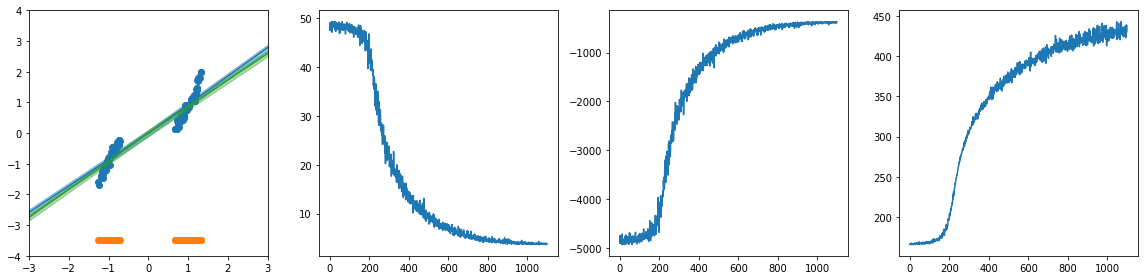

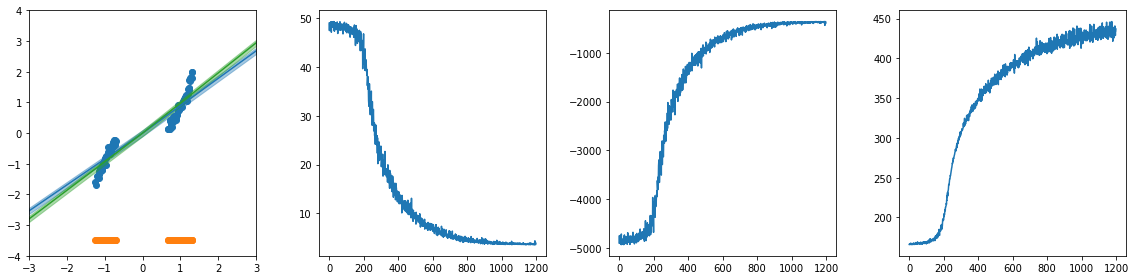

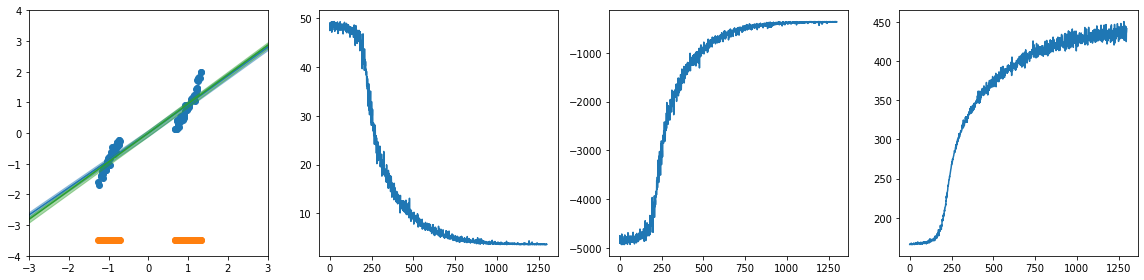

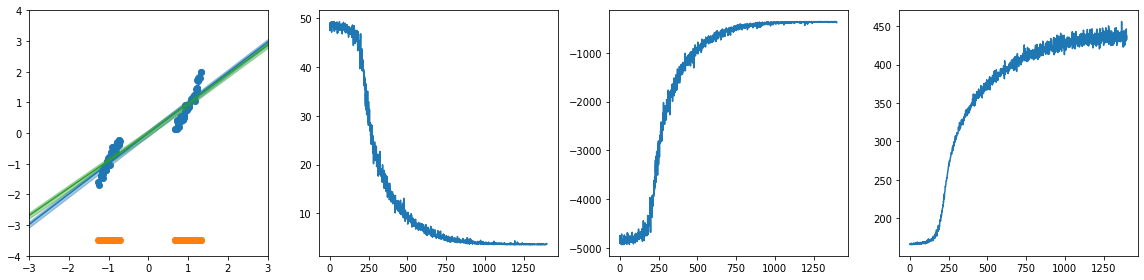

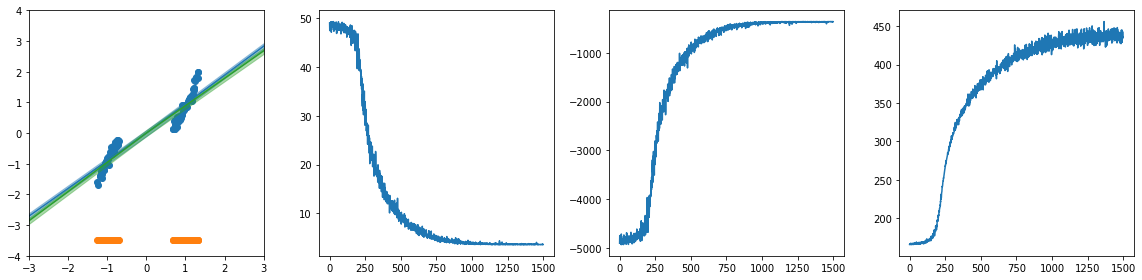

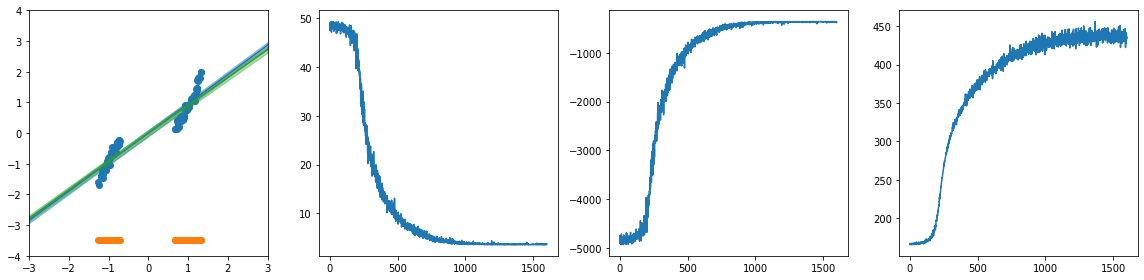

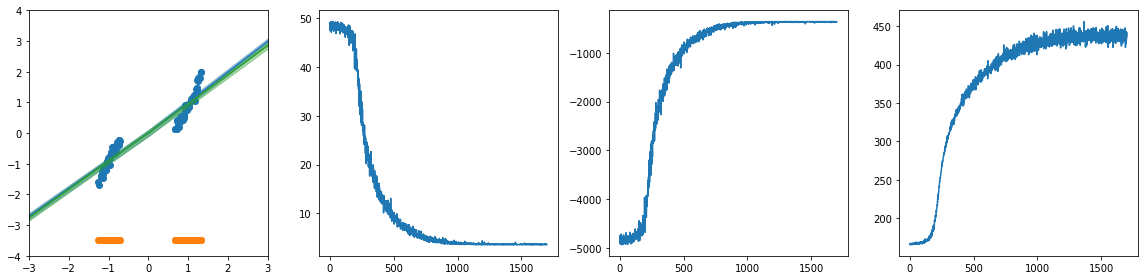

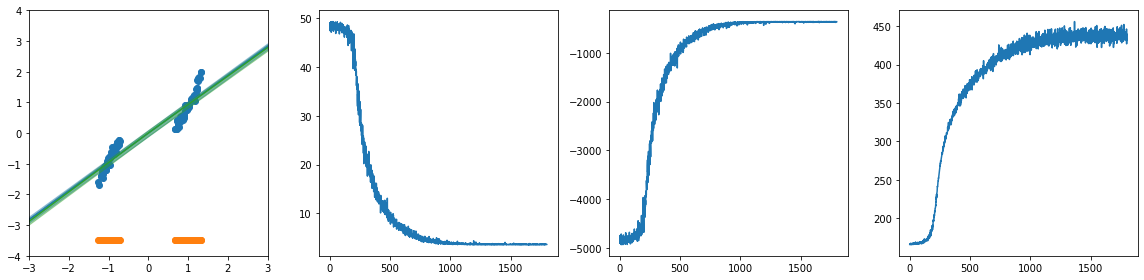

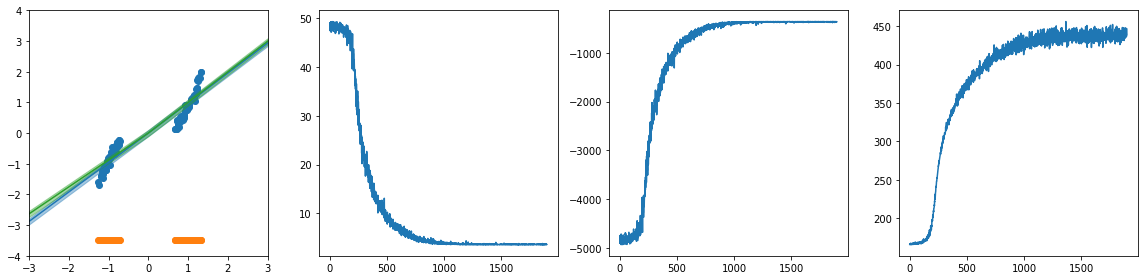

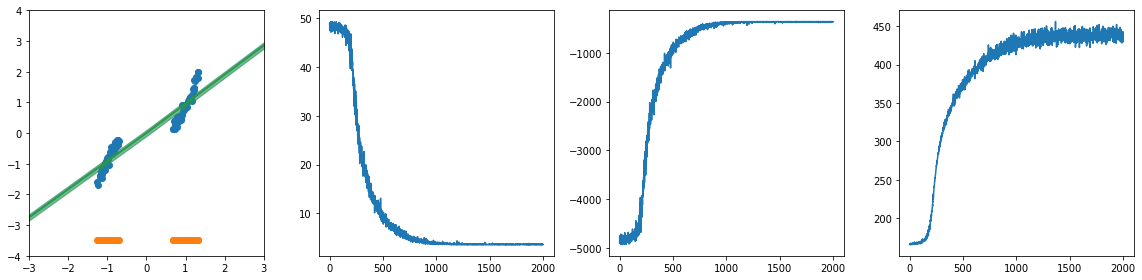

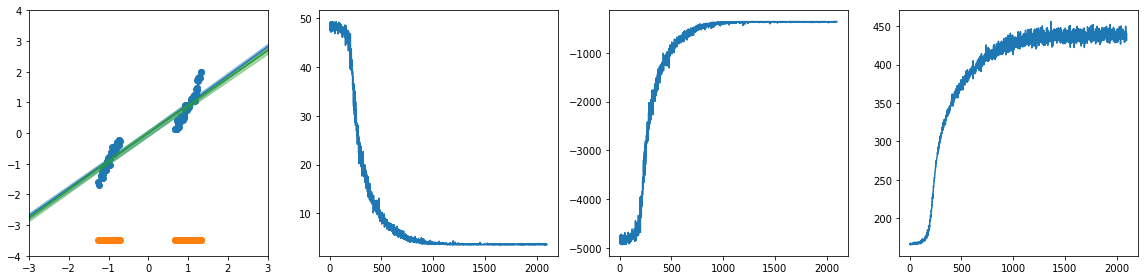

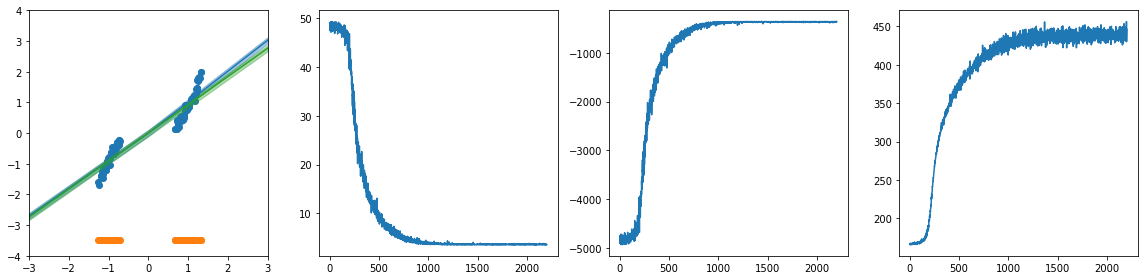

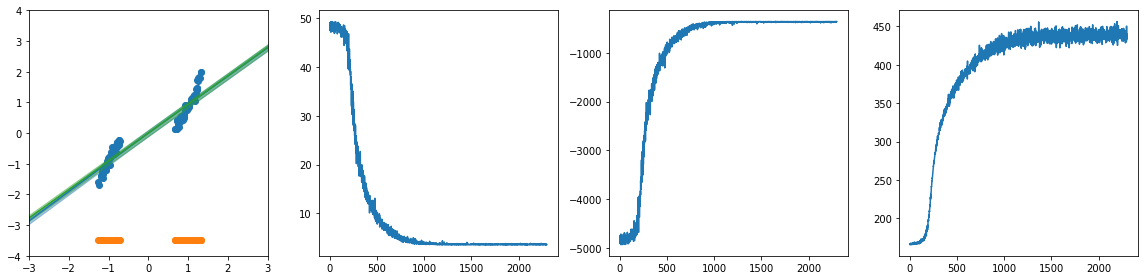

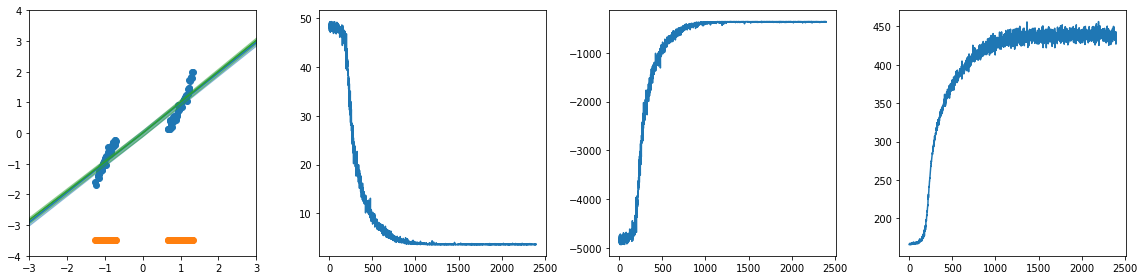

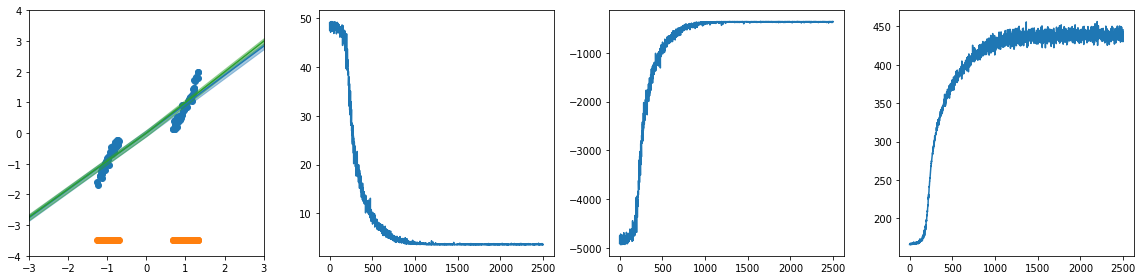

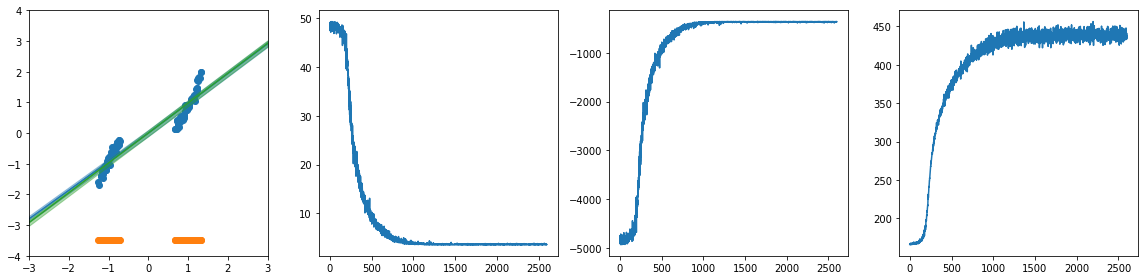

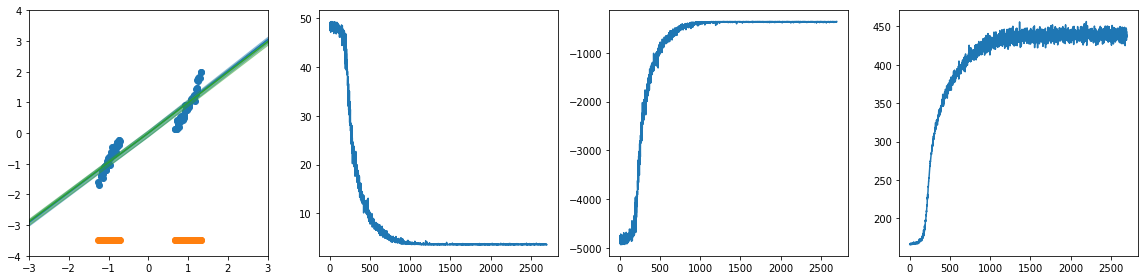

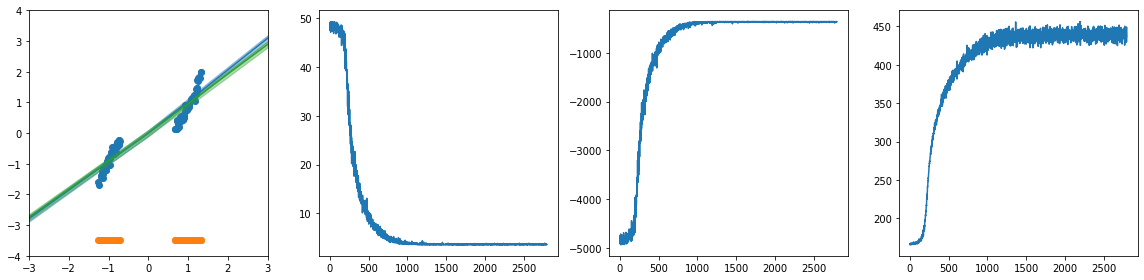

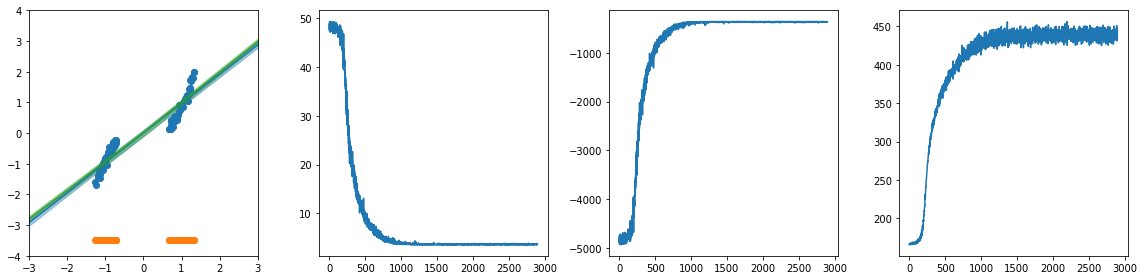

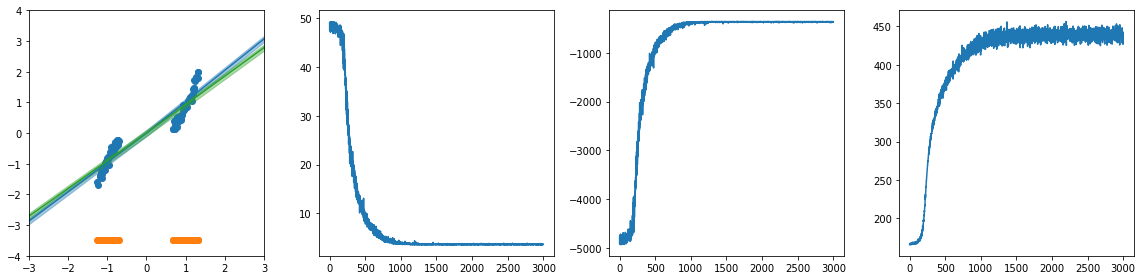

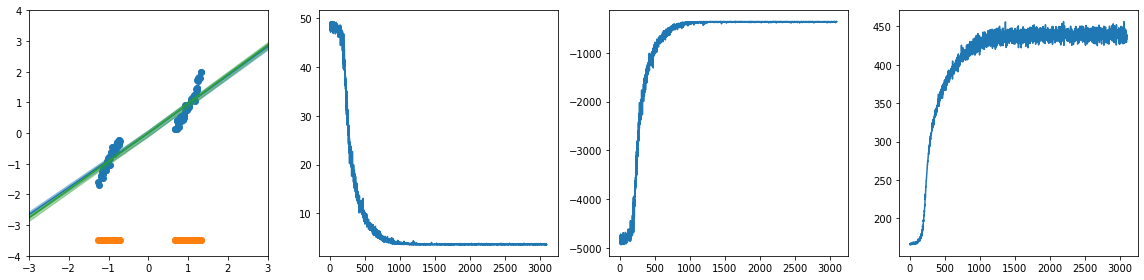

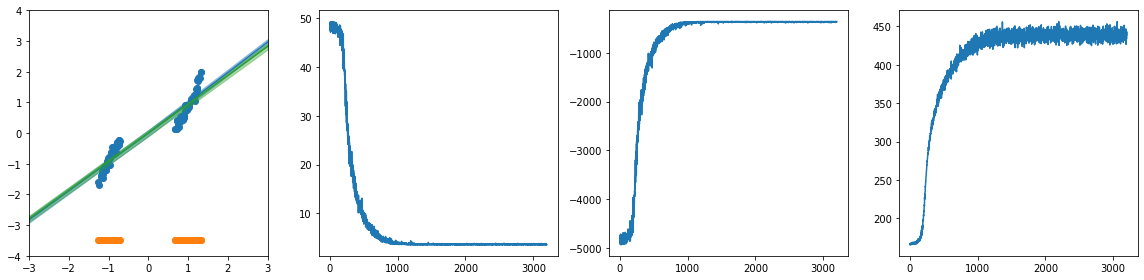

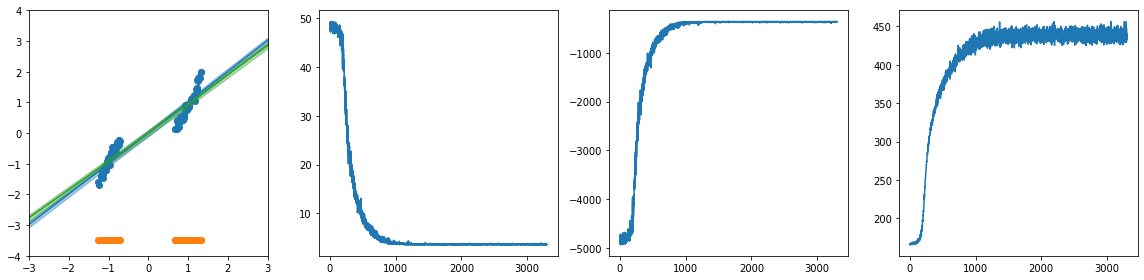

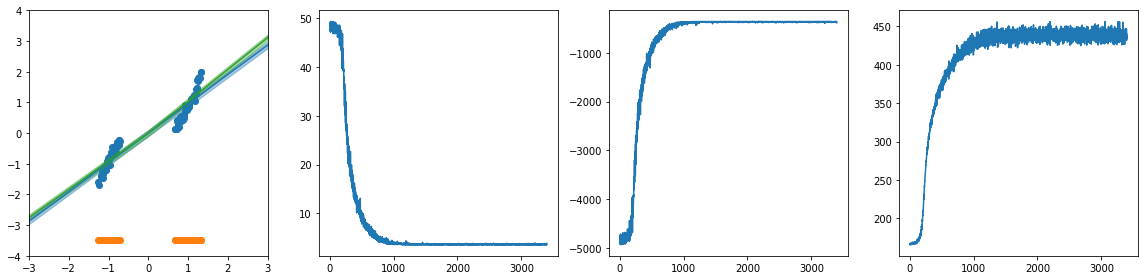

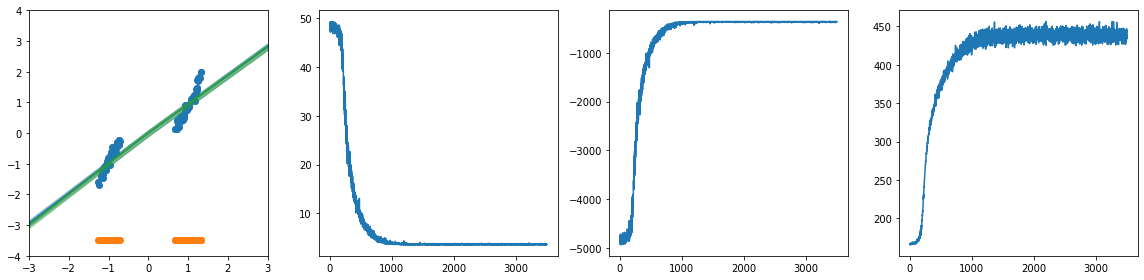

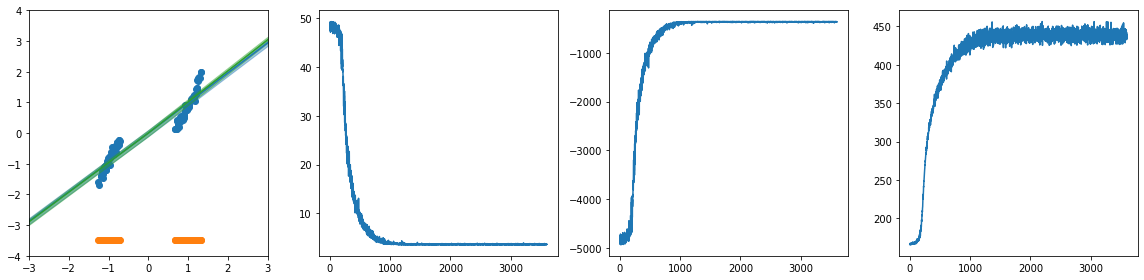

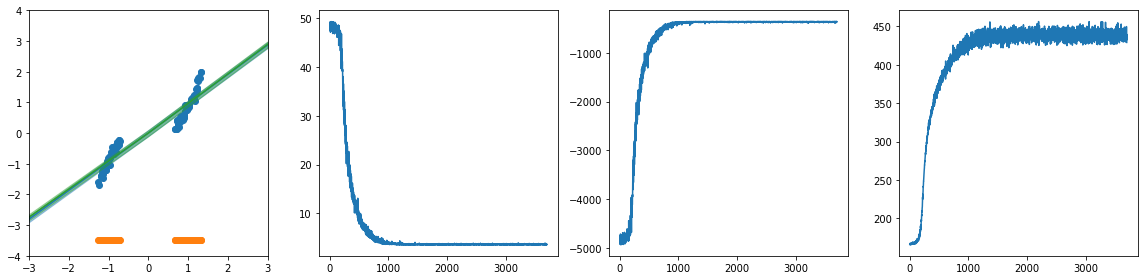

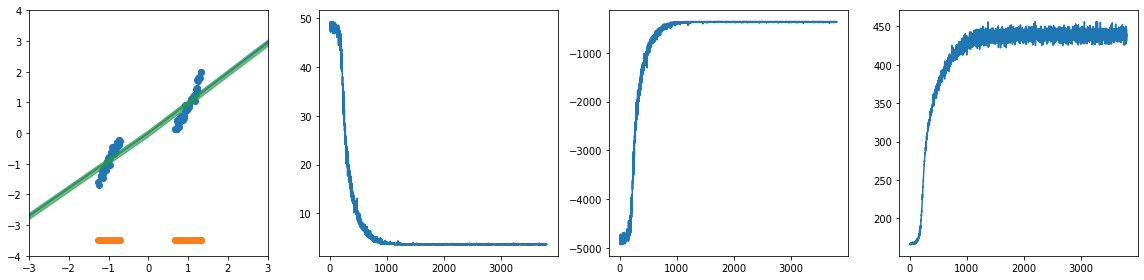

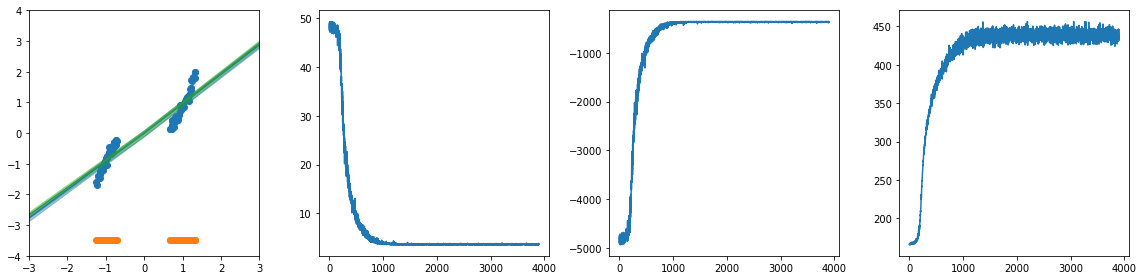

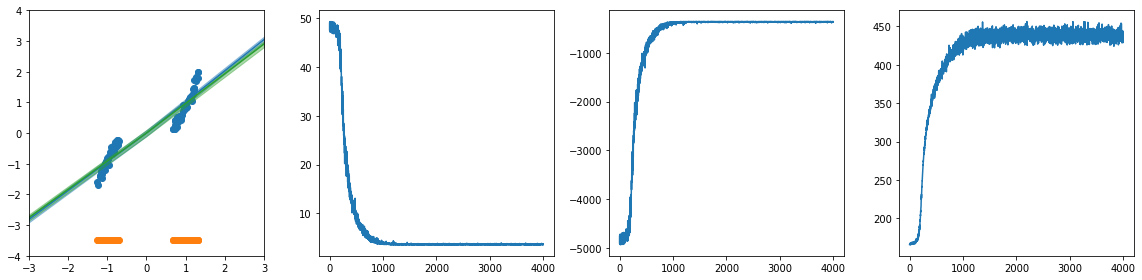

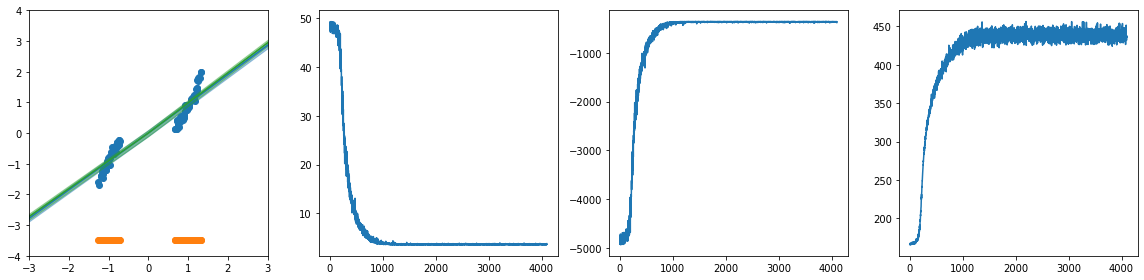

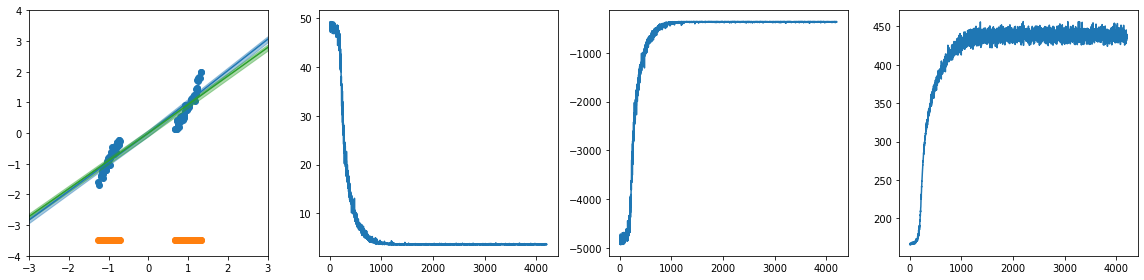

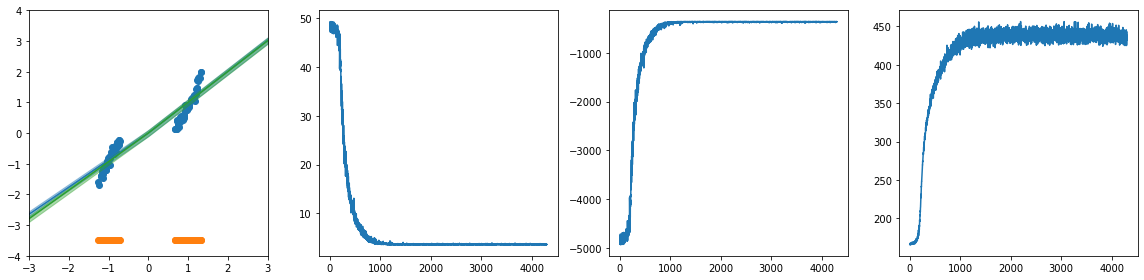

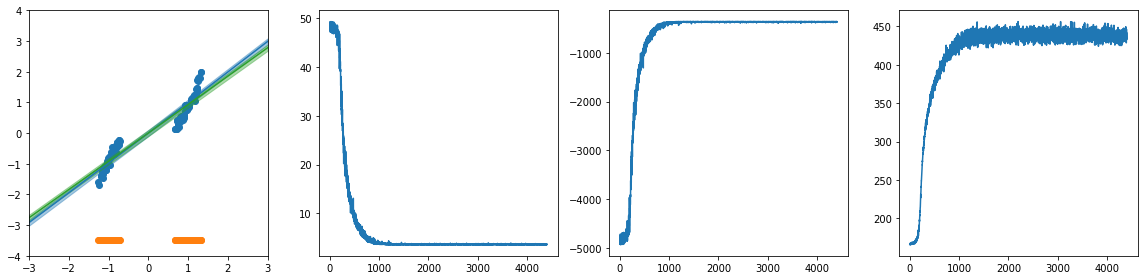

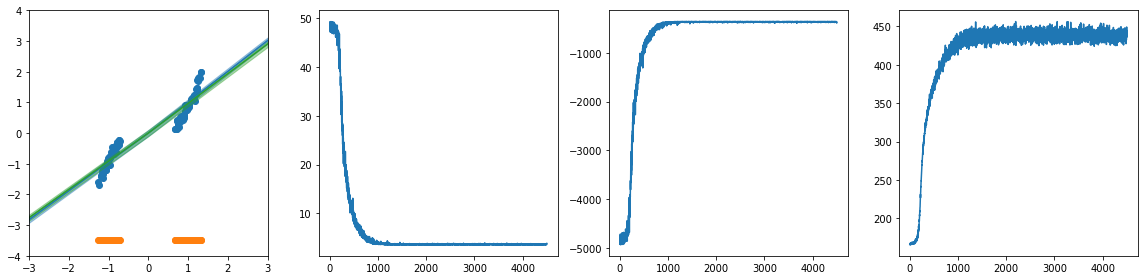

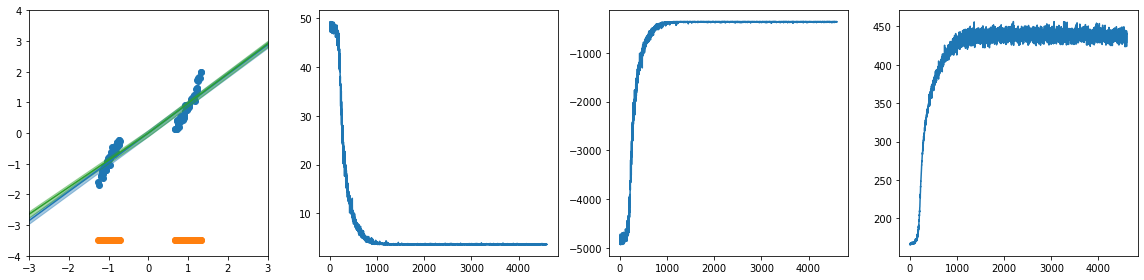

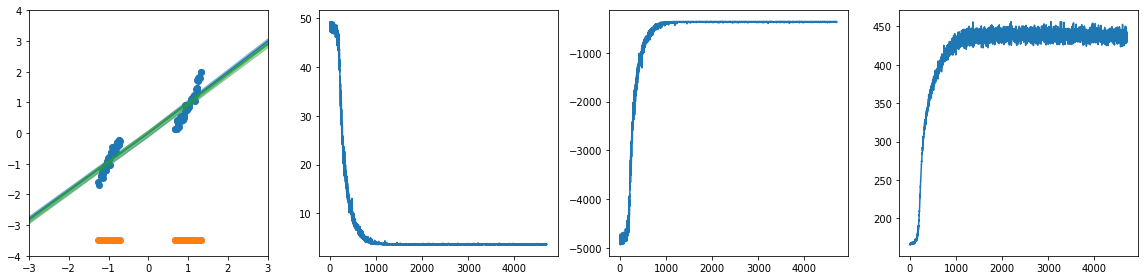

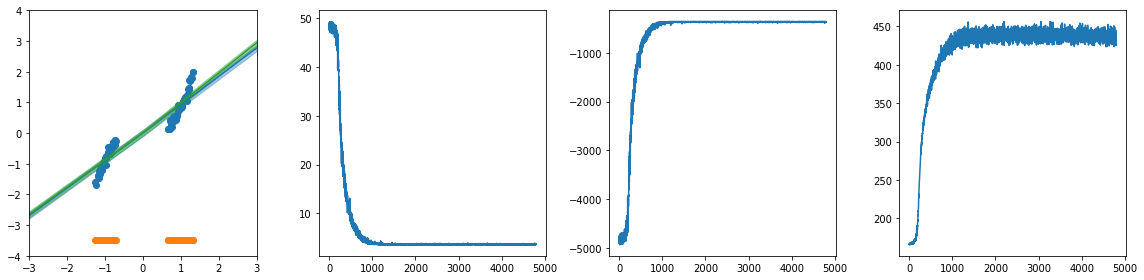

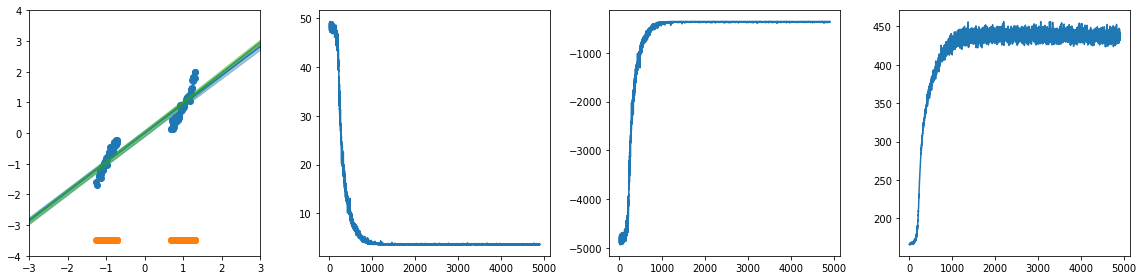

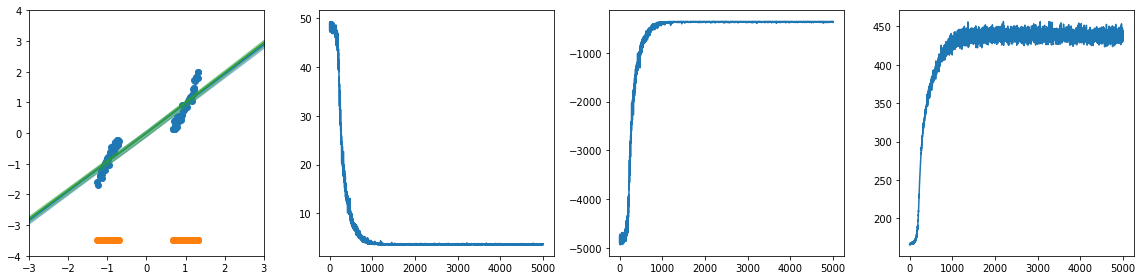

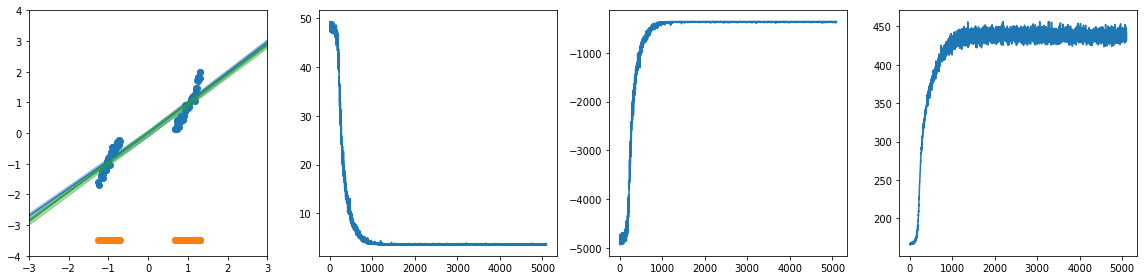

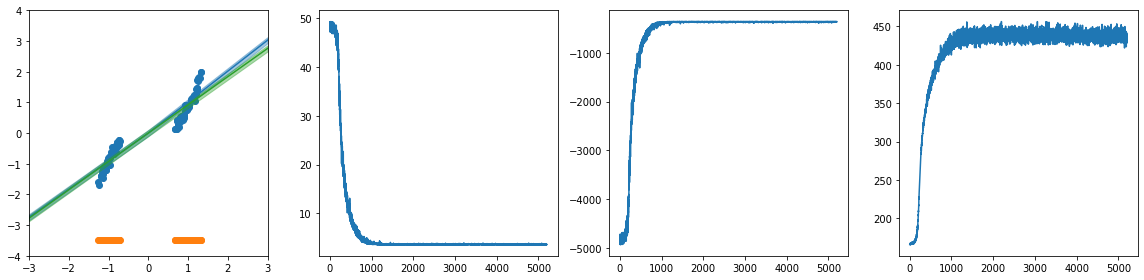

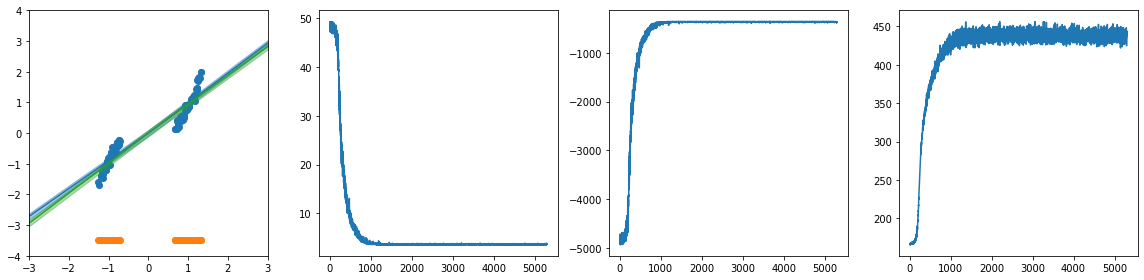

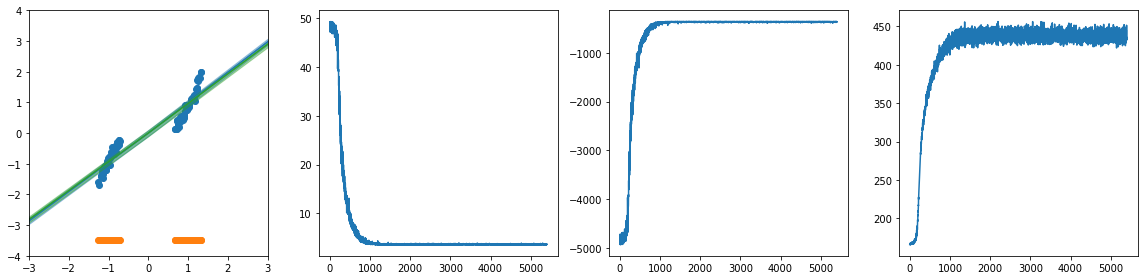

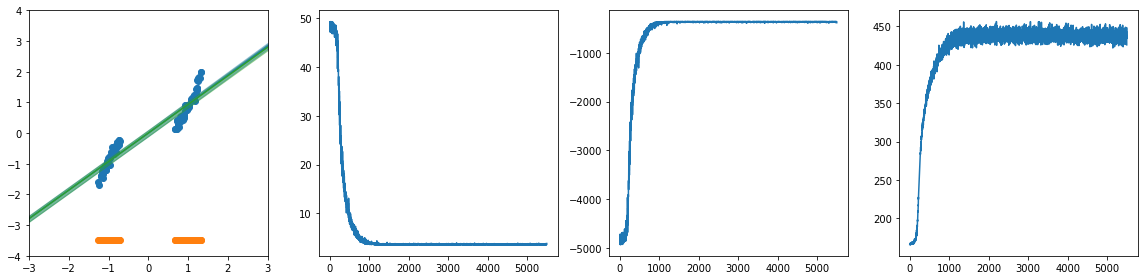

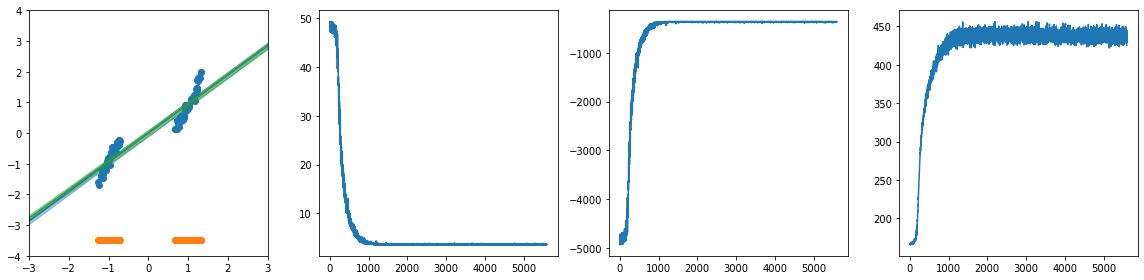

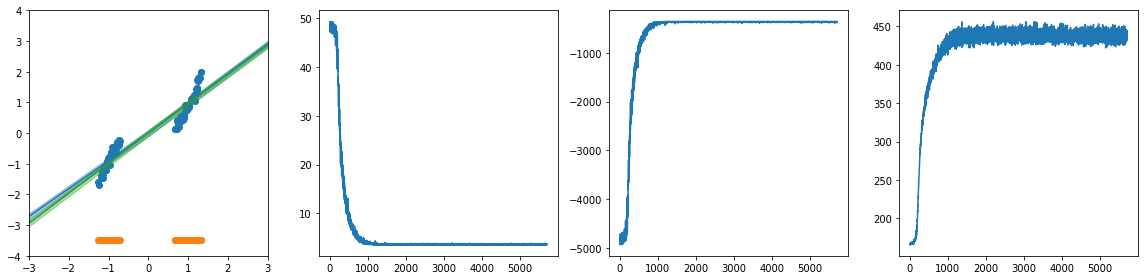

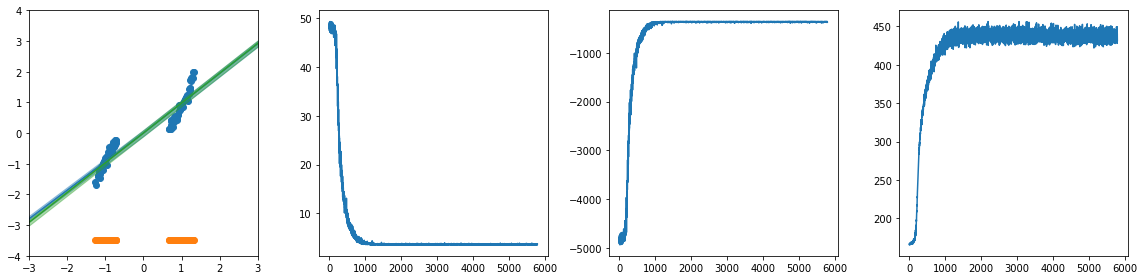

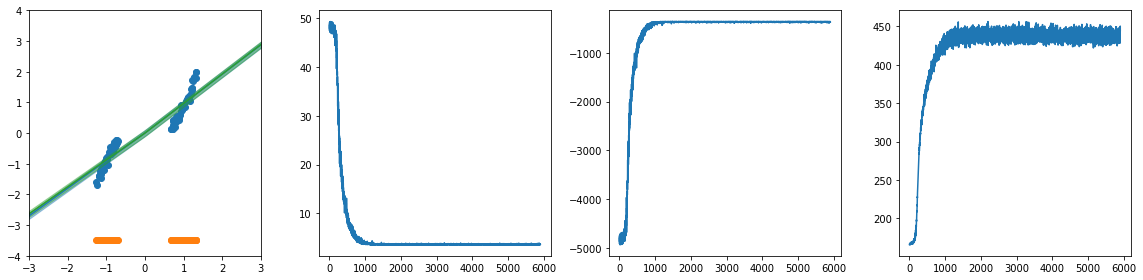

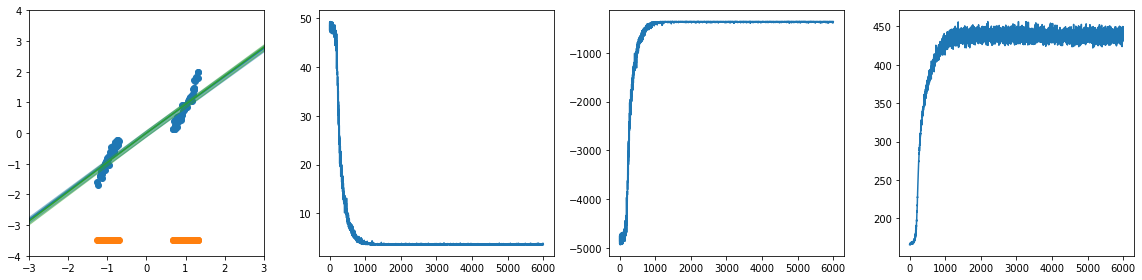

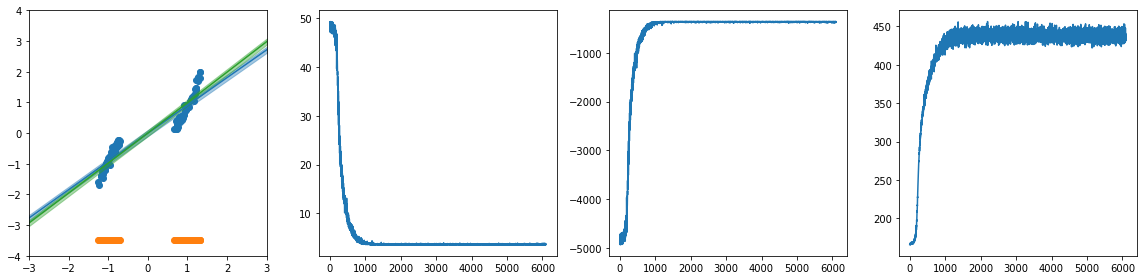

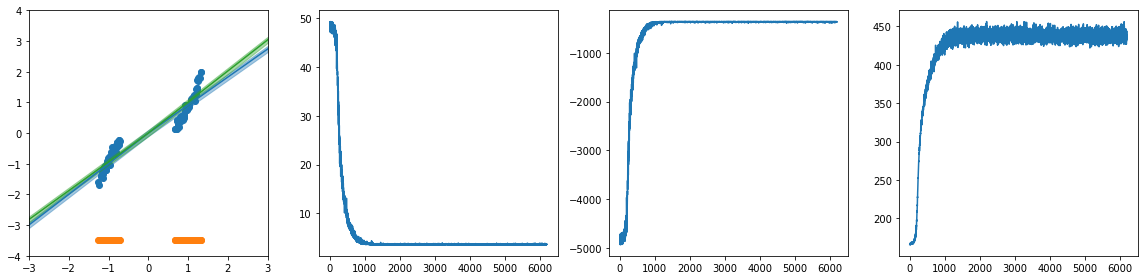

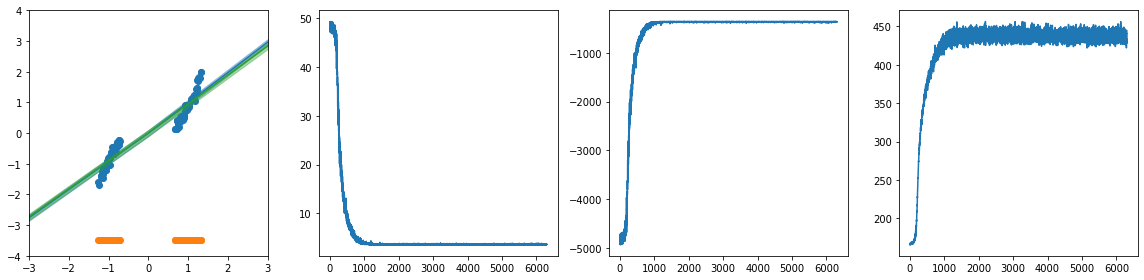

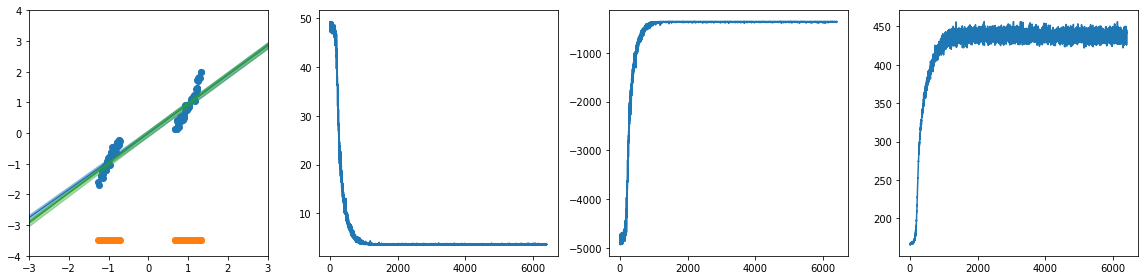

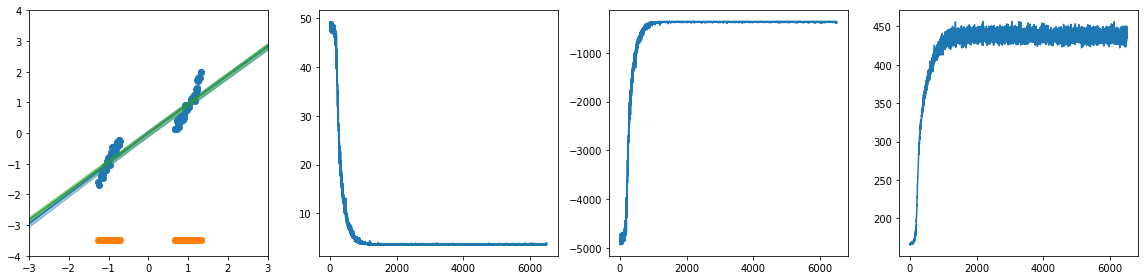

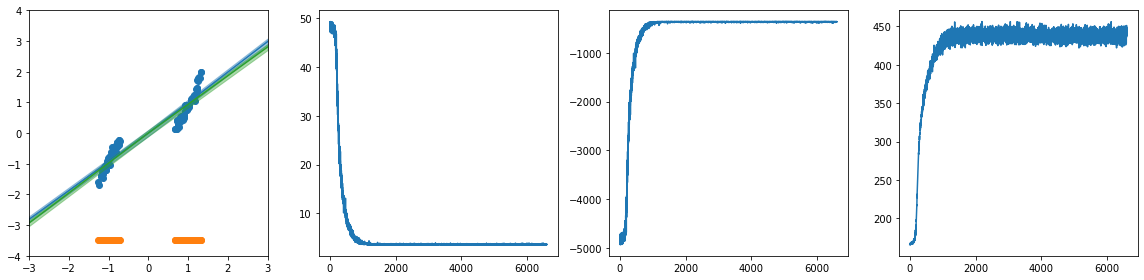

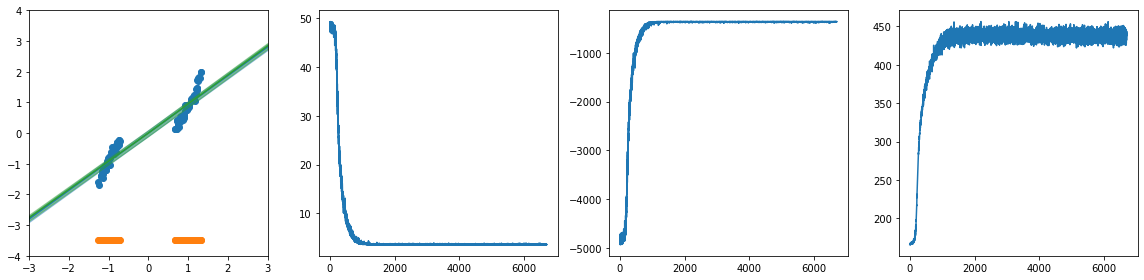

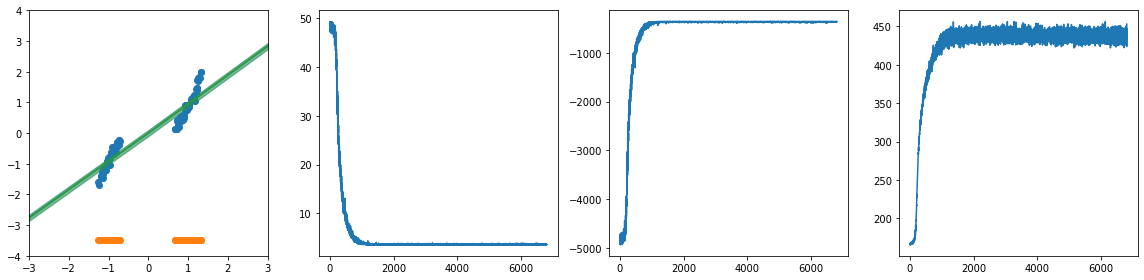

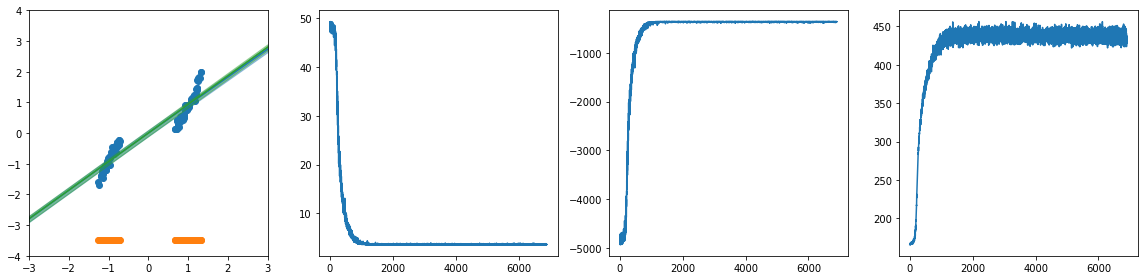

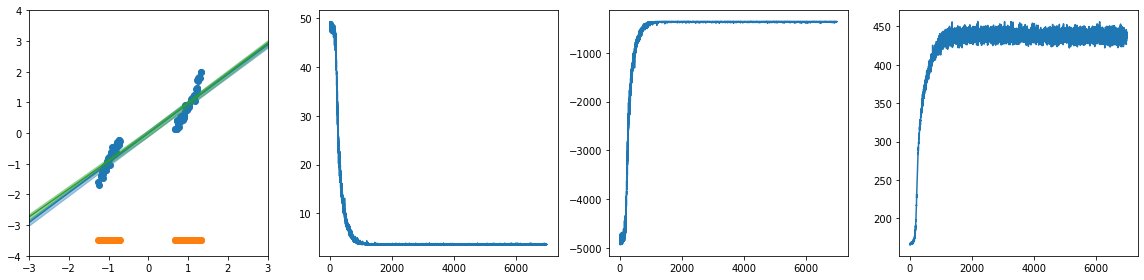

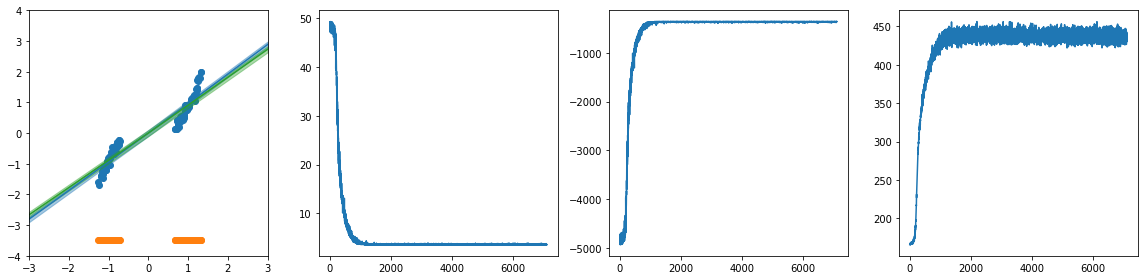

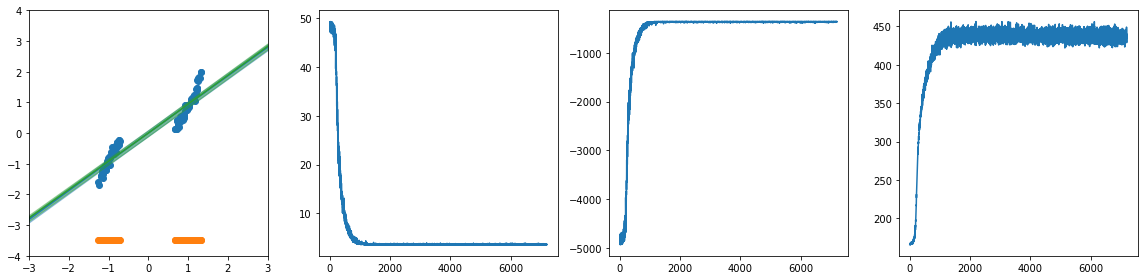

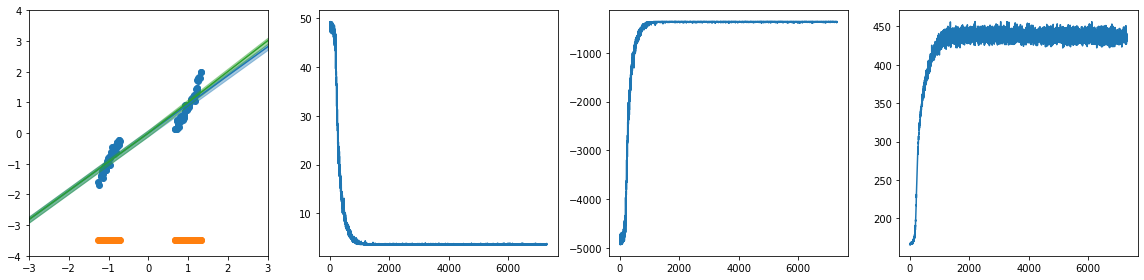

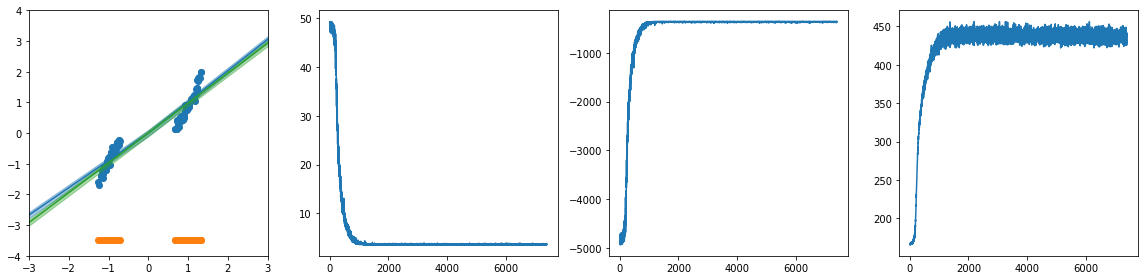

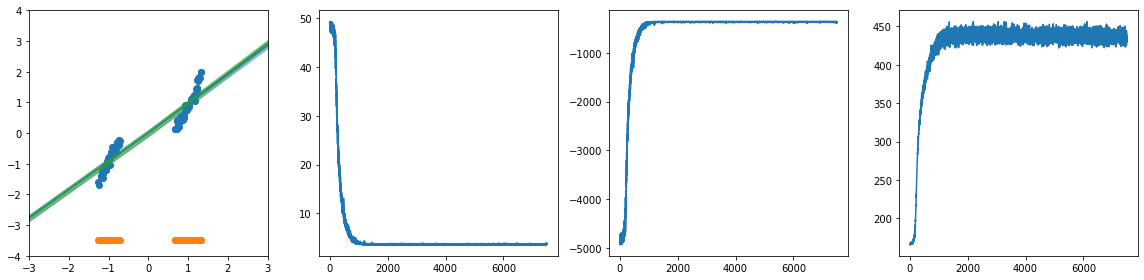

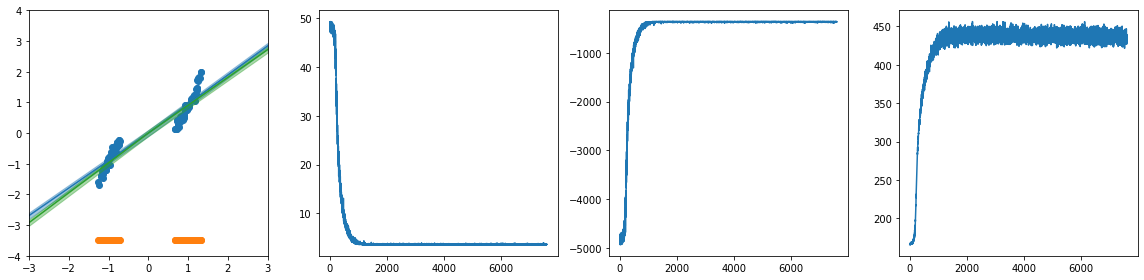

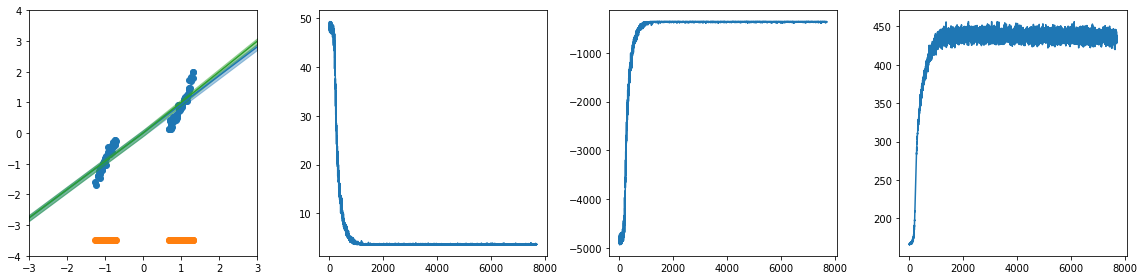

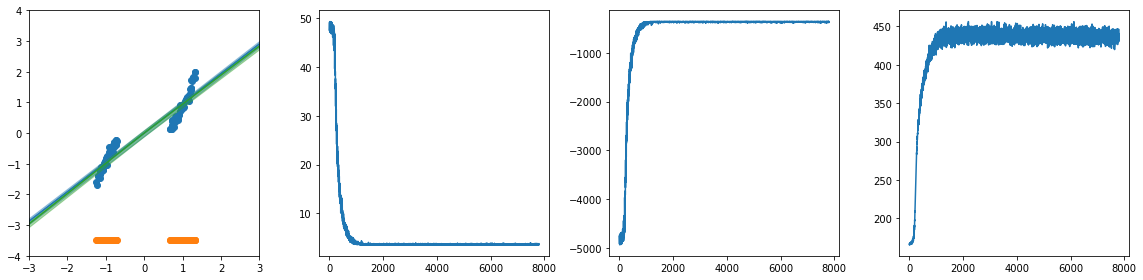

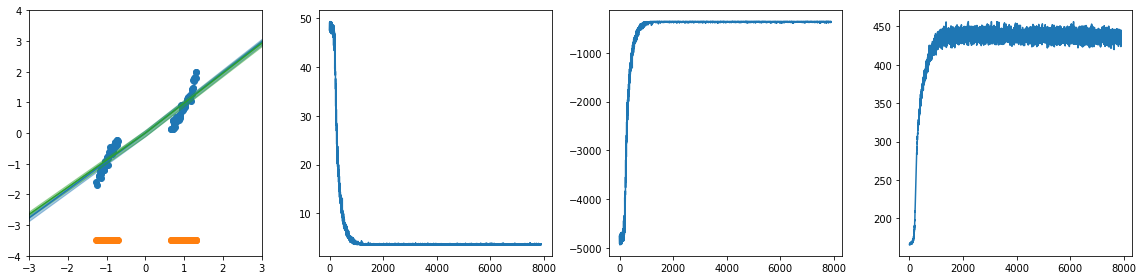

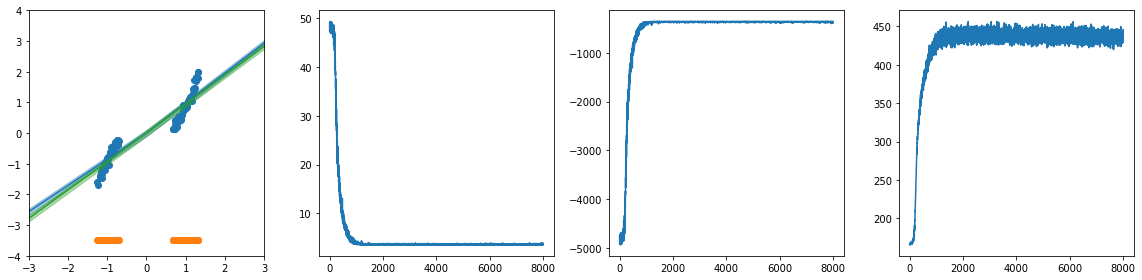

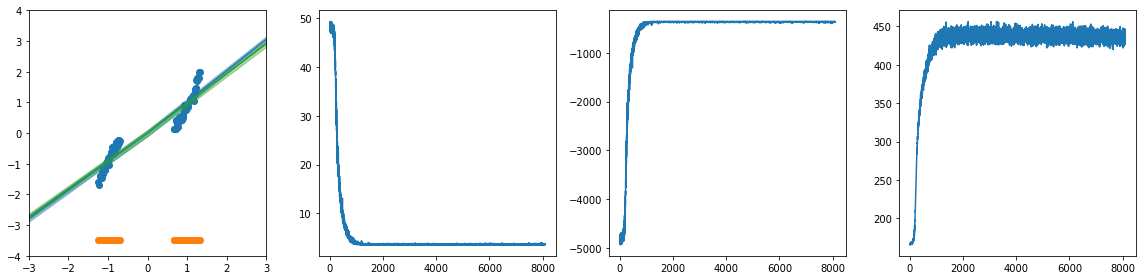

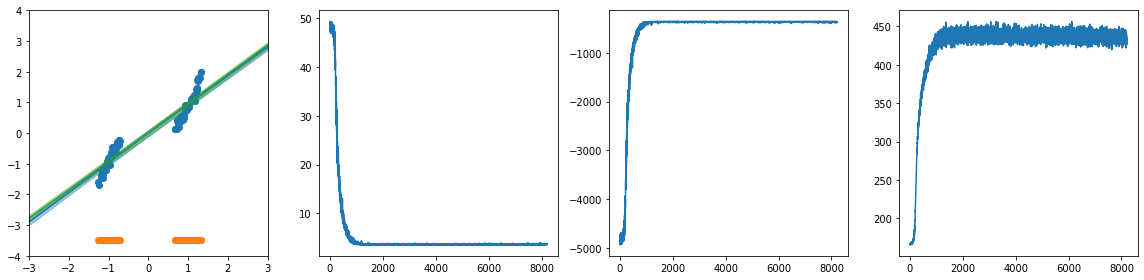

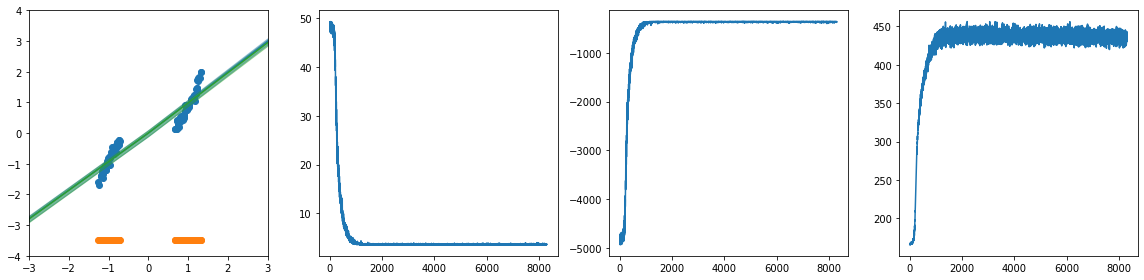

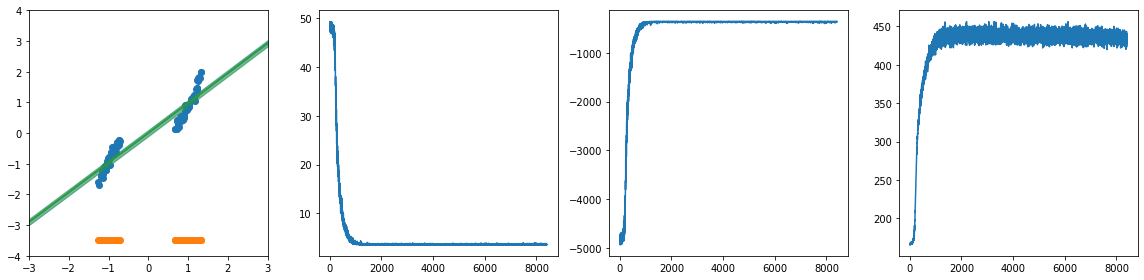

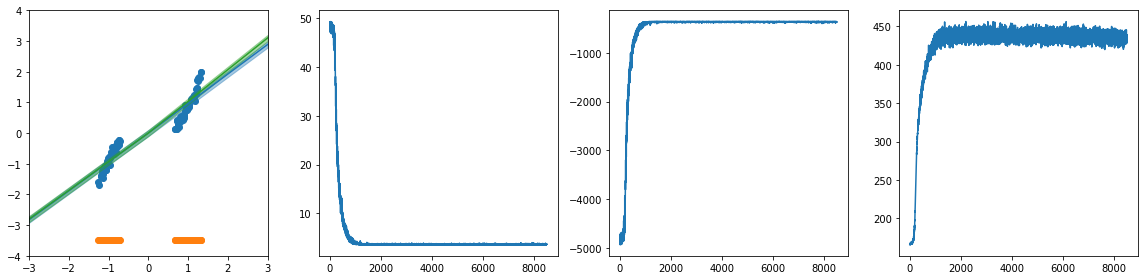

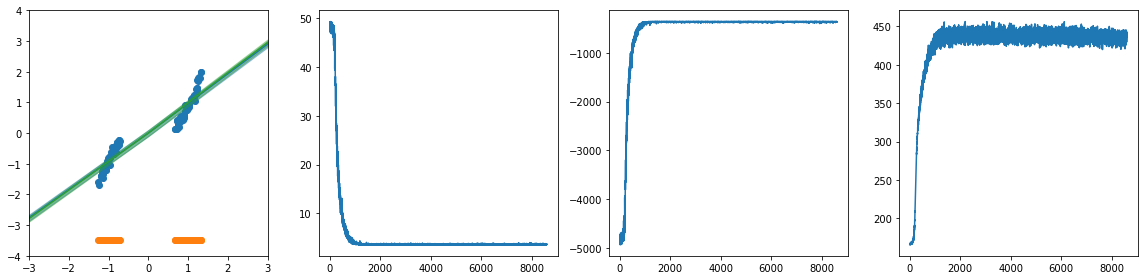

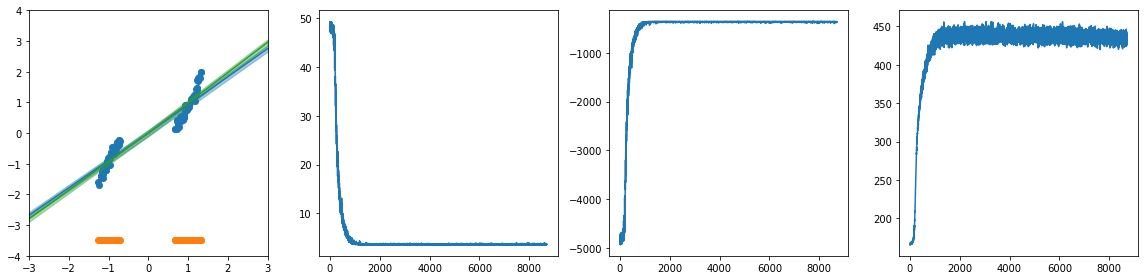

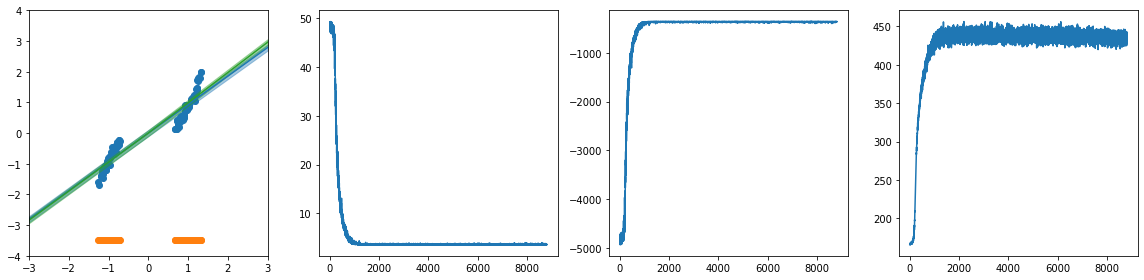

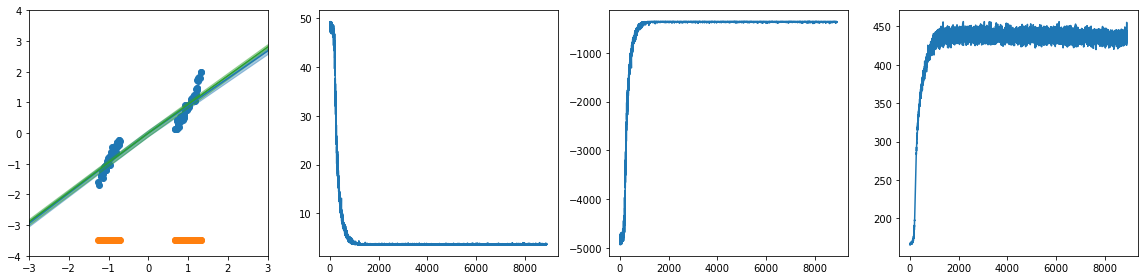

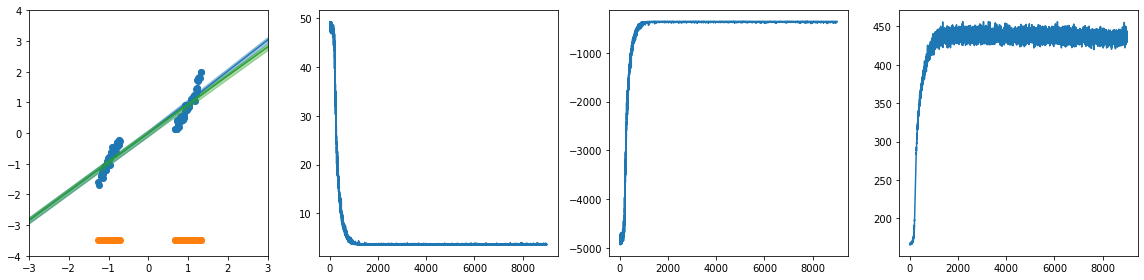

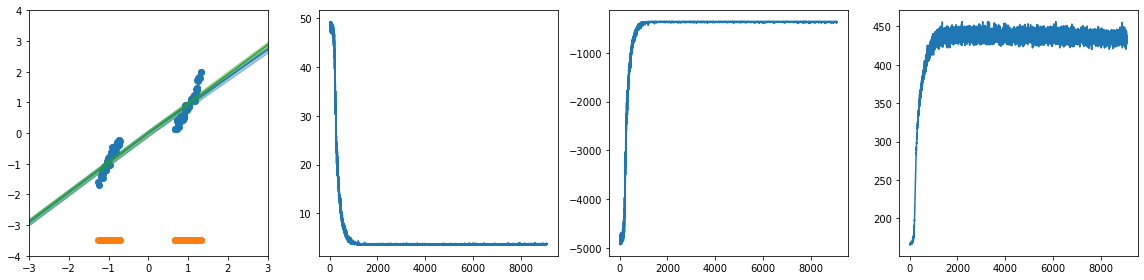

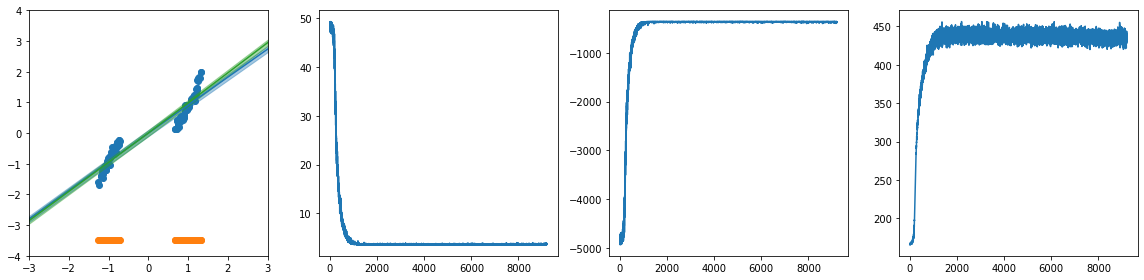

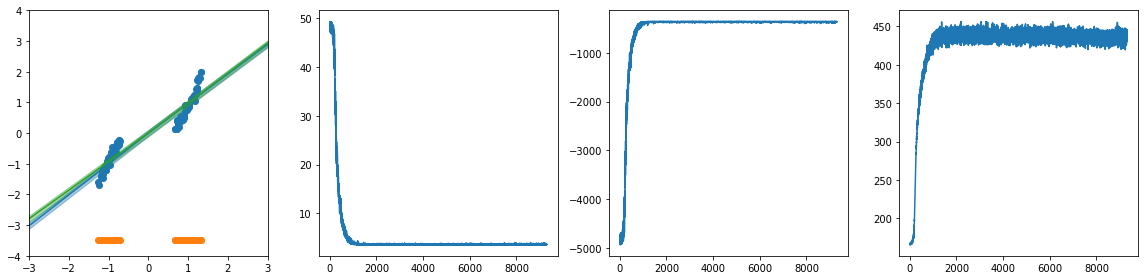

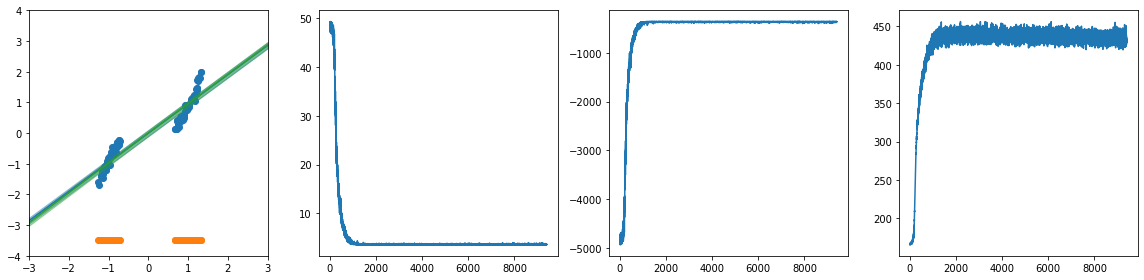

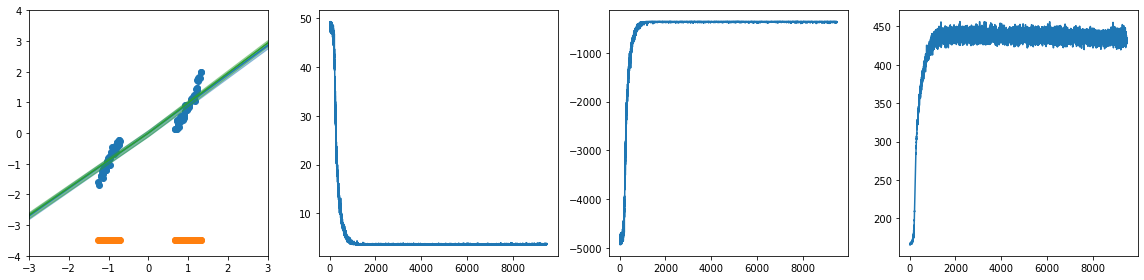

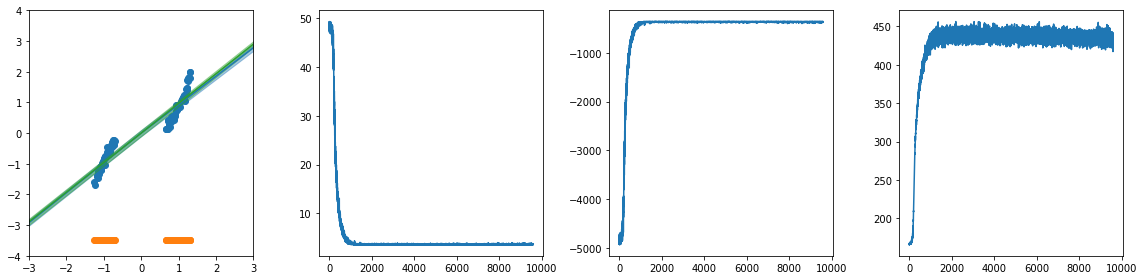

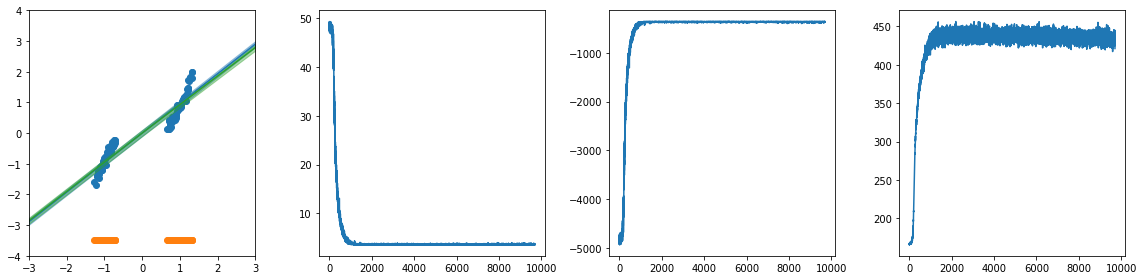

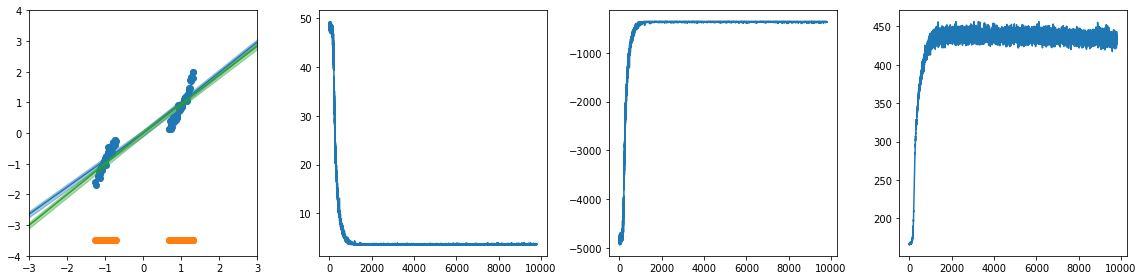

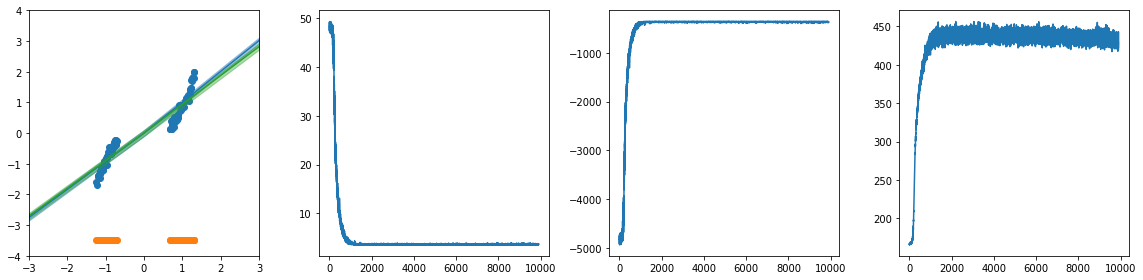

In [246]:
num_input = 1
num_output = 1
num_inducing = 100
dtype = tf.float32
nonlinearity = "relu"

inducing_idx = tf.random.shuffle(tf.range(x.shape[0]))[:num_inducing]
inducing_points = tf.gather(x, inducing_idx)

model = GlobalInducingFullyConnectedNetwork(
    num_input=num_input,
    num_output=num_output,
    inducing_points=inducing_points,
    nonlinearity=nonlinearity,
    dtype=dtype
)

optimiser = tfk.optimizers.Adam(learning_rate=1e-3)

losses = []
cond_liks = []
kls = []

for i in range(10000):

    if i % 100 == 0:
        
        x_plot = tf.linspace(-3., 3., 100)[:, None]
        
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 4, 1)
        
        plt.scatter(x[:, 0], y[:, 0])
        plt.scatter(
            model.inducing_points[:, 0],
            -3.5 * tf.ones_like(model.inducing_points[:, 0])
        )
        
        for color in ["tab:blue", "tab:green"]:
            
            mean, scale, _ = model(x_plot)

            plt.plot(x_plot[:, 0], mean[:, 0], color=color)

            plt.fill_between(
                x_plot[:, 0],
                mean[:, 0] - scale[:, 0],
                mean[:, 0] + scale[:, 0],
                color=color,
                alpha=0.4
            )
            
        plt.xlim([-3., 3.])
        plt.ylim([-4., 4.])
        
        plt.subplot(1, 4, 2)
        plt.plot(losses)
        
        plt.subplot(1, 4, 3)
        plt.plot(cond_liks)
        
        plt.subplot(1, 4, 4)
        plt.plot(kls)
        
        plt.tight_layout()
        plt.show()
    
    with tf.GradientTape() as tape:
        
        elbo, cond_lik, kl = model.elbo(x, y)
        loss = - elbo / x.shape[0]
        
        losses.append(loss)
        cond_liks.append(cond_lik)
        kls.append(kl)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))